# Métricas de desempenho

A partir de uma matriz de confusão, o objetivo desse código é executar os cálculos das principais métricas de avaliação de um modelo de ML. A partir do VP, VN, FP, e FN serão obtidas acurácia, precisão, sensibilidade, especificidade, F1-Score e Curva ROC.

In [5]:
!pip install --force-reinstall tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [6]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd

In [7]:
tf.__version__

'2.18.0'

In [8]:
%load_ext tensorboard

In [9]:
# Diretório do TensorBoard
logdir='log'

In [11]:
# Incorporando MNIST, dividindo dados de treino e teste, normalização e definição das classes

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28,1))
test_images = test_images.reshape((10000, 28, 28,1))

train_images, test_images = train_images / 255.0, test_images / 255.0

classes=[0,1,2,3,4,5,6,7,8,9]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Adicionando o modelo

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Criando a callback do TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [14]:
# Compilado e treinando o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=train_images,
          y=train_labels,
          epochs = 5,
          validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.8915 - loss: 0.3521 - val_accuracy: 0.9843 - val_loss: 0.0488
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - accuracy: 0.9833 - loss: 0.0524 - val_accuracy: 0.9869 - val_loss: 0.0375
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - accuracy: 0.9902 - loss: 0.0315 - val_accuracy: 0.9914 - val_loss: 0.0281
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9928 - loss: 0.0227 - val_accuracy: 0.9852 - val_loss: 0.0453
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9938 - loss: 0.0197 - val_accuracy: 0.9891 - val_loss: 0.0364


In [15]:
y_true = test_labels
y_pred = np.argmax(model.predict(test_images), axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [16]:
classes=[0,1,2,3,4,5,6,7,8,9]

In [17]:
# Criando o dataset da Matriz de Confusão

con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes,
                          columns = classes)

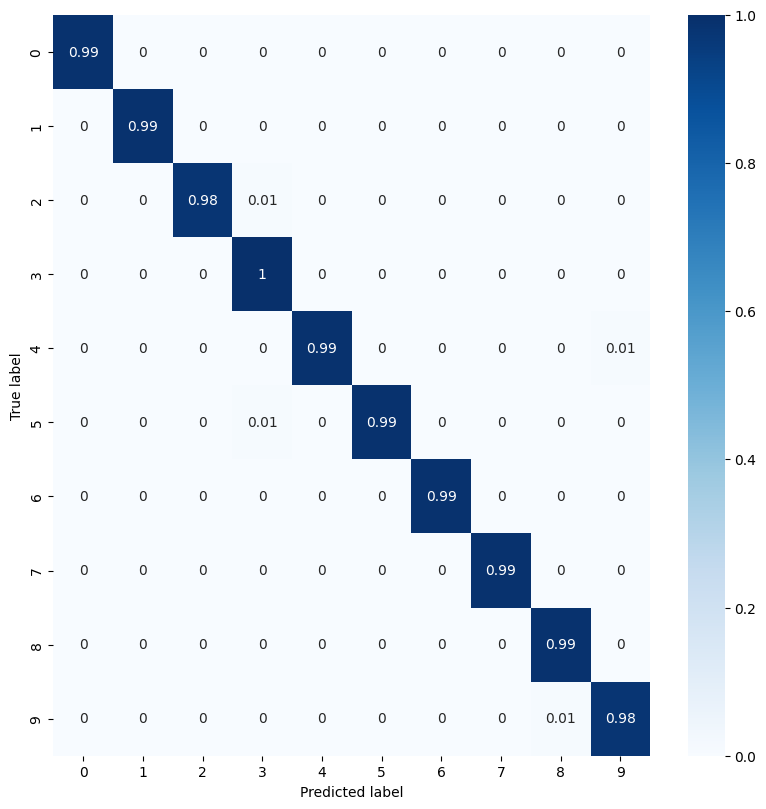

In [18]:
# Plotando a Matriz de Confusão

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
# Extraíndo as variáveis da Matriz de Confusão (VP, VN, FP, FN)

VP, FP, FN, VN = [], [], [], []

for i in range(len(classes)):
    vp = con_mat[i, i]  # Verdadeiro Positivo (diagonal principal)
    fp = np.sum(con_mat[:, i]) - vp  # Falso Positivo (soma da coluna menos VP)
    fn = np.sum(con_mat[i, :]) - vp  # Falso Negativo (soma da linha menos VP)
    vn = np.sum(con_mat) - (vp + fp + fn)  # Verdadeiro Negativo (restante da matriz)

    VP.append(vp)
    FP.append(fp)
    FN.append(fn)
    VN.append(vn)

# Converter listas para arrays NumPy (facilita operações vetorizadas)
VP, FP, FN, VN = np.array(VP), np.array(FP), np.array(FN), np.array(VN)

# Exibir os valores para cada classe
for i in range(len(classes)):
    print(f"Classe {classes[i]}: VP={VP[i]}, FP={FP[i]}, FN={FN[i]}, VN={VN[i]}")

Classe 0: VP=975, FP=11, FN=5, VN=9009
Classe 1: VP=1123, FP=2, FN=12, VN=8863
Classe 2: VP=1014, FP=10, FN=18, VN=8958
Classe 3: VP=1006, FP=28, FN=4, VN=8962
Classe 4: VP=974, FP=16, FN=8, VN=9002
Classe 5: VP=879, FP=5, FN=13, VN=9103
Classe 6: VP=948, FP=2, FN=10, VN=9040
Classe 7: VP=1016, FP=13, FN=12, VN=8959
Classe 8: VP=965, FP=9, FN=9, VN=9017
Classe 9: VP=991, FP=13, FN=18, VN=8978


In [20]:
# Calculando as métricas a partir das variáveis extraídas
accuracy = np.sum(VP + VN) / np.sum(VP + VN + FP + FN)
precision = VP / (VP + FP)
recall = VP / (VP + FN) # Sensibilidade
specificity = VN / (VN + FP)
f1_score = 2 * (precision * recall) / (precision + recall)

# Exibindo as métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão por classe: {precision}")
print(f"Precisão média: {np.mean(precision):.4f}")
print(f"Sensibilidade por classe: {recall}")
print(f"Sensibilidade média: {np.mean(recall):.4f}")
print(f"Especificidade por classe: {specificity}")
print(f"Especificidade média: {np.mean(specificity):.4f}")
print(f"F1-Score por classe: {f1_score}")
print(f"F1-Score médio: {np.mean(f1_score):.4f}")

Acurácia: 0.9978
Precisão por classe: [0.98884381 0.99822222 0.99023438 0.9729207  0.98383838 0.99434389
 0.99789474 0.98736638 0.99075975 0.98705179]
Precisão média: 0.9891
Sensibilidade por classe: [0.99489796 0.98942731 0.98255814 0.9960396  0.99185336 0.98542601
 0.98956159 0.98832685 0.99075975 0.98216056]
Sensibilidade média: 0.9891
Especificidade por classe: [0.99878049 0.99977439 0.99888492 0.99688543 0.99822577 0.99945103
 0.99977881 0.99855105 0.99900288 0.99855411]
Especificidade média: 0.9988
F1-Score por classe: [0.99186165 0.99380531 0.98638132 0.98434442 0.98782961 0.98986486
 0.99371069 0.98784638 0.99075975 0.9846001 ]
F1-Score médio: 0.9891


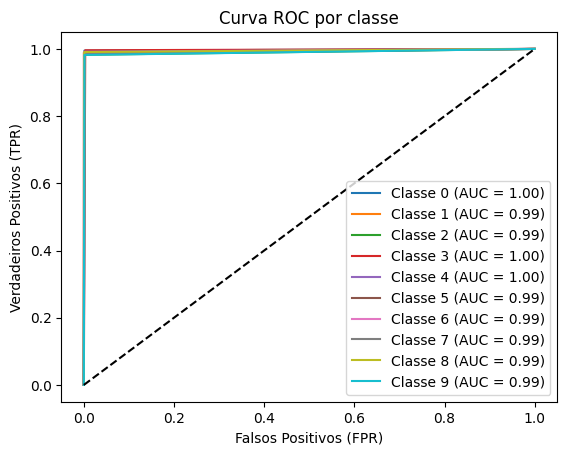

In [21]:
# Curva ROC e AUC utilizando Scikit-Learn

from sklearn.metrics import roc_curve, auc

# Criar as curvas ROC para cada classe (binária)
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred == i)  # Calcula os pontos da ROC
    roc_auc = auc(fpr, tpr)  # Área sob a curva

    plt.plot(fpr, tpr, label=f'Classe {classes[i]} (AUC = {roc_auc:.2f})')

# Plot final
plt.plot([0, 1], [0, 1], 'k--')  # Linha aleatória (AUC = 0.5)
plt.xlabel("Falsos Positivos (FPR)")
plt.ylabel("Verdadeiros Positivos (TPR)")
plt.title("Curva ROC por classe")
plt.legend()
plt.show()